正在处理样本：p21-p30.txt


C:\Users\征兵大队\AppData\Local\Temp\ipykernel_3920\865788965.py:147: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  with PdfPages(f'Data/{name}_所有指标.pdf') as pdf:


IndexError: index 1751 is out of bounds for axis 0 with size 1751

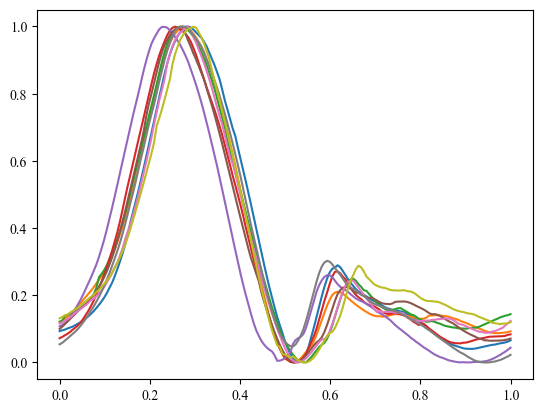

In [20]:
import os

from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.signal import peak_widths

PERIOD_WDITH_FLUCATE_FACTOR = 0.1
plt.rcParams['font.sans-serif'] = ['Times New Roman']

def getPeriodWidth(peaks):
    period_widths = []
    for i,peak in enumerate(peaks):
        if i < len(peaks) - 1:
            period_widths.append(peaks[i + 1] - peaks[i])
        else:
            break
    median_width = np.median(period_widths)
    return  median_width

    


def viewData(name, dat, factor='AngleL'):
    dat = dat[factor].values
    diff1 = numpy.diff(dat)
    _, axs = plt.subplots(2, 1, figsize=(20, 6))
    ax, ax2 = axs
    ax.plot(dat, color='red', label=factor)
    ax2.plot(diff1)
    ax.set_xlim(0, )
    ax2.set_xlim(0, )
    ax2.set_ylim(-2, 2)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.grid()
    ax.legend()
    #plt.show()
    plt.savefig(f"Data/{name}_观察_{factor}.pdf")
    plt.close()

def viewProcessedData(name, data, peak,factor='AngleL'):
    origin_dat = data[factor].values
    processed_dat = []

    _, axs = plt.subplots(3, 1, figsize=(36, 6))
    ax1, ax2 ,ax3= axs
    #plot origin data
    ax1.plot(origin_dat, color='red', label=factor)
    ax1.set_xlim(0, )
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.grid()
    ax1.legend()


    # plot proceessed data
    period_width = getPeriodWidth(peak)
    

    ax2.plot(origin_dat, color='#FFC0C0', linestyle='--',label='')
    start = 0
    for i, p in enumerate(peak):
        if i == len(peak) - 1:
            period = range(p, len(dat))
        else:
            period = range(p, peak[i + 1])
        

        if len(period) > (1 + PERIOD_WDITH_FLUCATE_FACTOR) * period_width or len(period) < (1 - PERIOD_WDITH_FLUCATE_FACTOR) * period_width:
            start += len(period)
            continue
        else:
            ax2.plot([x for x in period]  ,origin_dat[period], color='red',label='')
            start += len(period)
    ax2.set_xlim(0,)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.grid()

    for i, p in enumerate(peak):
        if i == len(peak) - 1:
            period = range(p, len(dat))
        else:
            period = range(p, peak[i + 1])

        if len(period) > (1 + PERIOD_WDITH_FLUCATE_FACTOR) * period_width or len(period) < (1 - PERIOD_WDITH_FLUCATE_FACTOR) * period_width:
            continue
        else:
            processed_dat.extend(origin_dat[period])


    ax3.plot(processed_dat, color='red', label=factor)
    # ax2.set_xlim(0,)
    ax3.set_xlim(0, )
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
   
    ax3.grid()
    ax3.legend()

    # ax3.legend()
    ax1.set_title('原始数据')
    ax2.set_title('取中的数据（虚线代表被删除的）')
    ax3.set_title('取中的数据直接横向拼在一起')

    plt.savefig(f'Data/{name}_观察处理后的_{factor}.pdf') 
    plt.close()

    


def findPeaks(data, H=30, D=100):
    # 使用 AngleL 寻找峰值
    data_peak = data['AngleL'].values
    peaks, _ = find_peaks(data_peak, height=H, distance=D)
    _, _, lefts, rights = peak_widths(data_peak, peaks)
    peaks = peaks.astype(int)
    lefts = lefts.astype(int)
    rights = rights.astype(int)
    period_width = getPeriodWidth(peaks)
    return rights +16
    #return rights + int(0.1*period_width)


def plotBySample(name, data, peak):
    period_width = getPeriodWidth(peak)
    colnames = list(data.columns[1:])
    # 保存两张图到一个PDF文件
    with PdfPages(f'Data/{name}_所有指标.pdf') as pdf:
        for factorsname in colnames:
            dat = data[factorsname].values
            max_length = max([len(dat[p:q]) for p, q in zip(peak, peak[1:])])
            normalized_profiles = []
            for i, p in enumerate(peak):

                if i == len(peak) - 1:
                    period = range(p, len(dat))
                else:
                    period = range(p, peak[i + 1])

                if len(period) > (1 + PERIOD_WDITH_FLUCATE_FACTOR) * period_width or len(period) < (1 - PERIOD_WDITH_FLUCATE_FACTOR) * period_width:
                    continue

                # 归一化x轴到0到1的范围
                x_normalized = (period - np.min(period)) / (np.max(period) - np.min(period))
                # 归一化y轴到0到1的范围
                y_normalized = (dat[period] - np.min(dat[period])) / (np.max(dat[period]) - np.min(dat[period]))
                # 使用插值方法补齐归一化峰型的长度
                f = interp1d(x_normalized, y_normalized, kind='linear')
                x_new = np.linspace(0, 1, max_length)
                y_new = f(x_new)
                plt.plot(x_new, y_new, label=f'Period {i+1}')
                # 将归一化峰型数据添加到数组中
                normalized_profiles.append(y_new)

            plt.xlabel('time ')
            plt.ylabel('value')
            plt.title(factorsname)

            plt.legend()
            pdf.savefig()
            plt.close()

            # 计算所有归一化峰型的平均值和标准差
            mean_profile = np.mean(normalized_profiles, axis=0)
            std_profile = np.std(normalized_profiles, axis=0)

            # 绘制平均值和标准差的图形
            plt.plot(x_new, mean_profile, color='red', label='Mean')
            plt.fill_between(x_new, mean_profile - std_profile, mean_profile + std_profile, color='gray', alpha=0.3, label='Standard Deviation')
            plt.xlabel('time')
            plt.ylabel('value')
            plt.title(factorsname)
            plt.legend()
            pdf.savefig()
            plt.close()


if __name__ == '__main__':
    file_list = [i for i in os.listdir('Data') if i.endswith('.txt')]
    for sample in file_list:
        print(f"正在处理样本：{sample}")
        dat = pandas.read_csv(f'Data/{sample}', sep='\t', index_col=False)
        viewData(sample[:3], dat)
        peak = findPeaks(dat, 30, 100)
        plotBySample(sample[:3], dat, peak)
        viewProcessedData(sample[:3], dat, peak)

